## Introduction

This notebook is for plotting the paht length of gammas and neutrons in liquid xenon. Gamma data from XCOM NIST (https://www.nist.gov/pml/xcom-photon-cross-sections-database) and neutron data from ENDF.

## Imports

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', size=22)
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rc('text', usetex=True)

## Settings

In [16]:
rho = 3.0

## Read data

In [17]:
def extract_nist(fn):
    all_params = []
    with open(fn, 'r') as f:
        for i, line in enumerate(f):
            # Skip header
            if i < 6: 
                continue
            #Skip blank lines
            if len(line) < 5:
                continue
            # Cut off the shell indication and newline character
            line = line[7:-1]
            params = [np.float(el) for el in line.split(sep=' ')]
            
            all_params.append(params)
            
    return np.array(all_params)

In [18]:
def extract_endf(fn):
    all_params = []
    with open(fn, 'r') as f:
        for i, line in enumerate(f):
            # Skip header
            if i < 5: 
                continue
            #Skip blank lines
            if len(line) < 5:
                continue
            # Cut off the shell indication and newline character
            line = line[2:-1]
            params = line.split(sep = ' ')
            params = [el for el in params if len(el) > 0]
            params = [el.replace('+', 'E+') for el in params]
            params = [el.replace('-', 'E-') for el in params]
            all_params.append(params)
    p = np.concatenate(all_params)
    p = np.array(p, dtype='float')
    p = np.reshape(p, (int(len(p) / 2), 2))
    return p

### Neutron data

In [19]:
dn = extract_endf('data/xenon_cross_section/neutron_sigma.txt')

In [20]:
en = dn[:, 0] * 1e-6

In [49]:
dnH = extract_endf('data/xenon_cross_section/neutron_sigma_H.txt')
enH = dnH[:, 0] * 1e-6
sigmanH = dnH[:, 1] * 1e-24 * 1.0 * 2 / 18 * 6.022e23 # Unit: 1/cm
# Cut off the zero element because zero cross section is not physical
sigmanH = sigmanH[1:]
enH = enH[1:]
attnH = 1/sigmanH # in cm

In [22]:
sigman = dn[:, 1] * 1e-24 * rho / 131.3 * 6.022e23 # Unit: 1/cm

In [23]:
# Cut off the zero element because zero cross section is not physical
sigman = sigman[1:]
en = en[1:]

In [24]:
attn = 1/sigman # in cm

### Gamma data

In [25]:
d = extract_nist('data/xenon_cross_section/gamma_sigma.txt')

In [26]:
e = d[:, 0]
sigma_coh    = d[:, 1] # Coherent
sigma_inc    = d[:, 2] # Incoherent. This is Compton scattering
sigma_pho    = d[:, 3] # photoelectric absorption
sigma_pp_nuc = d[:, 4] # pair production nuclear field
sigma_pp_el  = d[:, 5] # pair production electron field (order of magnitude below)
sigma_pp     = sigma_pp_nuc + sigma_pp_el
sigma_att = d[:, 7] # Total attenuation without coherent scattering
att = 1 / (rho * sigma_att) # Attenuation length

## Plots

### Gamma interactions

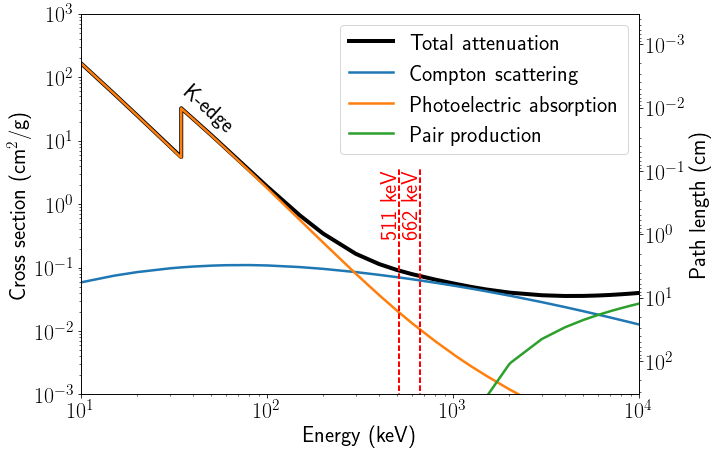

In [28]:
e_factor = 1e3
lw = 2.5
lw_thick = 4
plt.plot(e_factor * e, sigma_att, label='Total attenuation', color='black', lw=lw_thick)
plt.plot(e_factor * e, sigma_inc, label='Compton scattering', lw=lw)
plt.plot(e_factor * e, sigma_pho, label='Photoelectric absorption', lw=lw)
plt.plot(e_factor * e, sigma_pp , label='Pair production', lw=lw)

# plt.plot(e_factor * e, sigma_coh, label='Coherent')
# plt.plot(e_factor * e, sigma_pp_el , label='Electronic pair production')

plt.xlabel('Energy (keV)')
plt.ylabel('Cross section (cm$^2$/g)')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlim(10, 1e4)
plt.ylim(1e-3, 1e3)
for _e in (511, 662):
    # plt.axvline(_e, color='red', ls='--')
    plt.plot([_e, _e], [1e-4, 3.8e0], color='red', ls='--', lw=2)
    plt.text(_e * 0.8, 2, '%d keV' % _e, rotation=90, color='red')
    
plt.text(34, 50, 'K-edge', rotation = -42)
plt.twinx()
plt.ylim(1/(1e-3 * rho), 1/(1e3 * rho))
plt.yscale('log')
plt.ylabel('Path length (cm)')
plt.savefig('plots/cross_section_two_axis.pdf', bbox_inches='tight')

In [33]:
def compton_to_ph(E):
    '''
    Yields the ratio of Compton scattering to photoelectric absorption
    
    E in keV'''
    return (np.interp(E, 1e3 * e, sigma_inc) / 
            np.interp(E, 1e3 * e, sigma_pho))

In [34]:
def pp_to_compton(E):
    '''
    Yields the ratio of pair production to Compton scattering
    
    E in keV'''
    return (np.interp(E, 1e3 * e, sigma_pp) / 
            np.interp(E, 1e3 * e, sigma_inc))

In [35]:
def pp_to_total(E):
    '''
    Yields the ratio of pair production to Compton scattering
    
    E in keV'''
    return (np.interp(E, 1e3 * e, sigma_pp) / 
            np.interp(E, 1e3 * e, sigma_att))

In [36]:
# Equality at around 300 keV
compton_to_ph(296.94)

1.0001843097531715

In [37]:
compton_to_ph(662)

5.550748445131592

In [38]:
compton_to_ph(511)

3.494614809274495

In [39]:
pp_to_compton(1274)

0.005579191555391794

In [40]:
pp_to_total(1274)

0.005243530088866778

### Attenuation length

(0.001, 10)

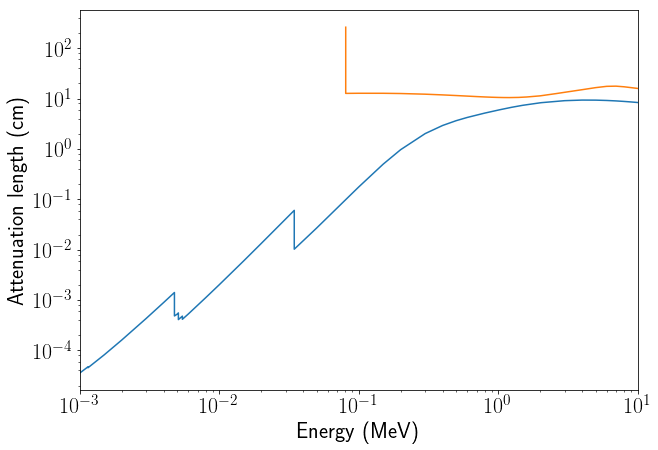

In [41]:
plt.plot(e, att)
plt.plot(en, attn)
plt.xlabel('Energy (MeV)')
plt.ylabel('Attenuation length (cm)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-3, 10)

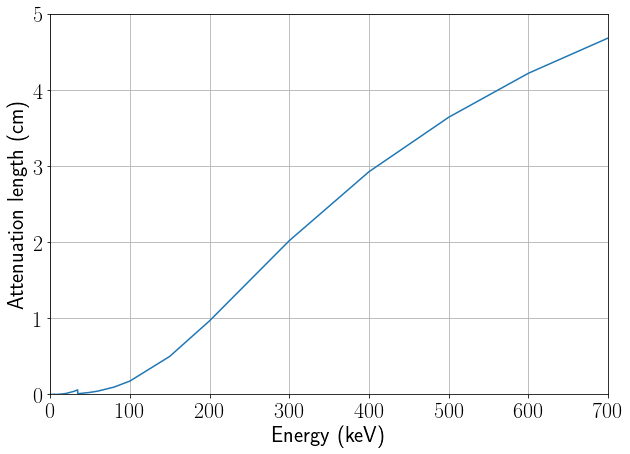

In [42]:
plt.plot(1000 * e, att)
# plt.plot(en, attn)
plt.xlabel('Energy (keV)')
plt.ylabel('Attenuation length (cm)')
# plt.xscale('log')
# plt.yscale('log')
plt.xlim(0, 700)
plt.ylim(0, 5)
plt.grid()

In [43]:
def get_att(E, e, att):
    return np.interp(E, e, att)

In [44]:
print('Length at 100 keV: %.2f cm' % get_att(0.1, e, att))

Length at 100 keV: 0.18 cm


In [45]:
print('Length at 1 MeV: %.2f cm' % get_att(1, e, att))

Length at 1 MeV: 5.91 cm


In [46]:
print('Length at Tl-208: %.2f cm ' % get_att(2.615, e, att))


Length at Tl-208: 8.78 cm 


In [47]:
print('Length at 1 MeV neutron: %.2f cm' % (np.interp(1, en, attn)))

Length at 1 MeV neutron: 10.55 cm


In [48]:
print('Length at 10 MeV neutron: %.2f cm' % (np.interp(10, en, attn)))

Length at 10 MeV neutron: 15.92 cm


In [25]:
print('Length at 200 keV: %.2f cm' % get_att(0.2, e, att))

Length at 200 keV: 0.97 cm


### Neutrons in water

(0.001, 10)

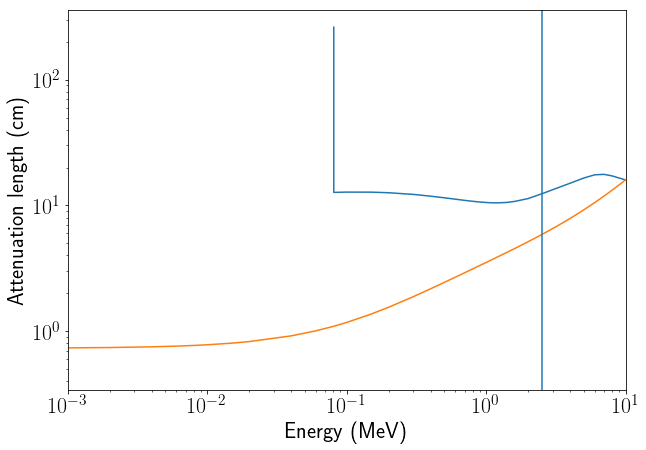

In [52]:
plt.plot(en, attn, label='Xenon')
plt.plot(enH, attnH, label='Water')
plt.axvline(2.5)
plt.xlabel('Energy (MeV)')
plt.ylabel('Attenuation length (cm)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-3, 10)

In [55]:
print('Length at 2.45 MeV neutron (Xe) : %.2f cm' % (np.interp(2.45, en, attn)))
print('Length at 2.45 MeV neutron (H2O): %.2f cm' % (np.interp(2.45, enH, attnH)))

Length at 2.45 MeV neutron (Xe) : 12.25 cm
Length at 2.45 MeV neutron (H2O): 5.79 cm
